# Tutorial on GraphNN

We try to build a GraphNN that recognize if an image contains a rectangle or a circle, representing the image as a point cloud

In [1]:
#from https://github.com/vermaMachineLearning/keras-deep-graph-learning.git
import tensorflow.keras.backend as K
import tensorflow as tf


def graph_conv_op(x, num_filters, graph_conv_filters, kernel):

    if len(x.get_shape()) == 2:
        conv_op = K.dot(graph_conv_filters, x)
        conv_op = tf.split(conv_op, num_filters, axis=0)
        conv_op = K.concatenate(conv_op, axis=1)
    elif len(x.get_shape()) == 3:
        conv_op = K.batch_dot(graph_conv_filters, x)
        conv_op = tf.split(conv_op, num_filters, axis=1)
        conv_op = K.concatenate(conv_op, axis=2)
    else:
        raise ValueError('x must be either 2 or 3 dimension tensor'
                         'Got input shape: ' + str(x.get_shape()))

    conv_out = K.dot(conv_op, kernel)
    return conv_out

from tensorflow.keras import activations, initializers, constraints
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
import tensorflow as tf

class MultiGraphCNN(Layer):

    def __init__(self,
                 output_dim,
                 num_filters,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(MultiGraphCNN, self).__init__(**kwargs)

        self.output_dim = output_dim
        self.num_filters = num_filters

        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_initializer.__name__ = kernel_initializer
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

    def build(self, input_shape):

        if self.num_filters != int(input_shape[1][-2]/input_shape[1][-1]):
            raise ValueError('num_filters does not match with graph_conv_filters dimensions.')

        self.input_dim = input_shape[0][-1]
        kernel_shape = (self.num_filters * self.input_dim, self.output_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.output_dim,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs):

        output = graph_conv_op(inputs[0], self.num_filters, inputs[1], self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = (input_shape[0][0], input_shape[0][1], self.output_dim)
        return output_shape

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'num_filters': self.num_filters,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(MultiGraphCNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Import useful stuff

In [2]:
import numpy as np
from math import *
from matplotlib import pyplot as plt 
#device_name = tf.test.gpu_device_name()
#print(device_name)

# Load the dataset

In [ ]:
!git clone https://github.com/pierinim/tutorials.git
!mv tutorials/GNN_Pisa_Nov2021/data .

In [3]:
# load one file
import h5py
f = h5py.File("data/ShapeClassifier_Circle0.9_Noise0.3.h5", "r")
#f = h5py.File("data/ShapeClassifier_Circle0.9_Rectangle0.7.h5", "r")
X_train = np.array(f.get("X_train"))
X_test = np.array(f.get("X_test"))
Y_train = np.array(f.get("Y_train"))
Y_test = np.array(f.get("Y_test"))
A_train = np.array(f.get("A_train"))
A_test = np.array(f.get("A_test"))
f.close()    

In [4]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)
print(A_train.shape, A_test.shape)

(700, 100, 3) (300, 100, 3)
(700,) (300,)
(700, 100, 100) (300, 100, 100)


# Now we define the Classifier
We use an implementation of Graph Convolutional Layers, distributed with
https://vermamachinelearning.github.io/keras-deep-graph-learning/

In [9]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Dropout,Flatten,Reshape
from tensorflow.keras.models import Model, Sequential
    
NUM_FILTERS = 1
graph_conv_filters = A_train 
graph_conv_filters = K.constant(graph_conv_filters)
    
X_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))
    
hidden =  MultiGraphCNN(2, NUM_FILTERS, activation='relu', kernel_initializer='random_normal')([X_input,graph_conv_filters_input])
hidden = Dropout(0.4)(hidden)
hidden =  MultiGraphCNN(1, NUM_FILTERS, activation='relu', kernel_initializer='random_normal')([hidden,graph_conv_filters_input])
hidden = Dropout(0.4)(hidden)
hidden = Flatten()(hidden)
output = Dense(1, activation='sigmoid', kernel_initializer='random_normal')(hidden)
loss="binary_crossentropy"
model = Model(inputs=[X_input,graph_conv_filters_input], outputs=output)
model.compile(loss=loss, optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
multi_graph_cnn_2 (MultiGraphCN (None, 100, 2)       8           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 100, 2)       0           multi_graph_cnn_2[0][0]    

In [10]:
history = model.fit([X_train, graph_conv_filters],Y_train,validation_split=0.3, epochs=400, verbose=1)

Epoch 1/200
16/16 [==============================] - 1s 15ms/step - loss: 0.6939 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.4408
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.4784 - val_loss: 0.6930 - val_accuracy: 0.5071
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5391 - val_loss: 0.6931 - val_accuracy: 0.5071
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4709 - val_loss: 0.6930 - val_accuracy: 0.5071
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.4541 - val_loss: 0.6930 - val_accuracy: 0.5071
Epoch 6/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5022 - val_loss: 0.6929 - val_accuracy: 0.5071
Epoch 7/200
16/16 [==============================] - 0s 11ms/step - loss: 0.6918 - accuracy: 0.5480 - val_loss: 0.6928 - val_accuracy: 0.5071
Epoch 8/200

Epoch 59/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3311 - accuracy: 0.9725 - val_loss: 0.3422 - val_accuracy: 0.9668
Epoch 60/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3645 - accuracy: 0.9479 - val_loss: 0.3366 - val_accuracy: 0.9668
Epoch 61/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3815 - accuracy: 0.9399 - val_loss: 0.3324 - val_accuracy: 0.9668
Epoch 62/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3405 - accuracy: 0.9546 - val_loss: 0.3316 - val_accuracy: 0.9668
Epoch 63/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3508 - accuracy: 0.9396 - val_loss: 0.3238 - val_accuracy: 0.9763
Epoch 64/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3332 - accuracy: 0.9565 - val_loss: 0.3215 - val_accuracy: 0.9668
Epoch 65/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3379 - accuracy: 0.9473 - val_loss: 0.3210 - val_accuracy: 0.9668
Epoch 

16/16 [==============================] - 0s 4ms/step - loss: 0.2218 - accuracy: 0.9481 - val_loss: 0.1878 - val_accuracy: 0.9810
Epoch 117/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2167 - accuracy: 0.9562 - val_loss: 0.1948 - val_accuracy: 0.9810
Epoch 118/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2194 - accuracy: 0.9568 - val_loss: 0.1939 - val_accuracy: 0.9810
Epoch 119/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2517 - accuracy: 0.9228 - val_loss: 0.1853 - val_accuracy: 0.9858
Epoch 120/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2075 - accuracy: 0.9541 - val_loss: 0.1917 - val_accuracy: 0.9810
Epoch 121/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2211 - accuracy: 0.9462 - val_loss: 0.1887 - val_accuracy: 0.9858
Epoch 122/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2594 - accuracy: 0.9468 - val_loss: 0.1789 - val_accuracy: 0.9810
Epoch 123/200

16/16 [==============================] - 0s 4ms/step - loss: 0.1981 - accuracy: 0.9467 - val_loss: 0.1340 - val_accuracy: 0.9858
Epoch 174/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1618 - accuracy: 0.9620 - val_loss: 0.1378 - val_accuracy: 0.9858
Epoch 175/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1453 - accuracy: 0.9697 - val_loss: 0.1299 - val_accuracy: 0.9810
Epoch 176/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2004 - accuracy: 0.9362 - val_loss: 0.1234 - val_accuracy: 0.9858
Epoch 177/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2671 - accuracy: 0.8894 - val_loss: 0.1274 - val_accuracy: 0.9810
Epoch 178/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1622 - accuracy: 0.9545 - val_loss: 0.1322 - val_accuracy: 0.9858
Epoch 179/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2374 - accuracy: 0.9260 - val_loss: 0.1221 - val_accuracy: 0.9858
Epoch 180/200

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


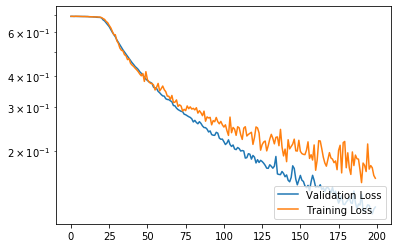

In [11]:
print(history.history.keys())
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history.history["loss"], label="Training Loss")
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()

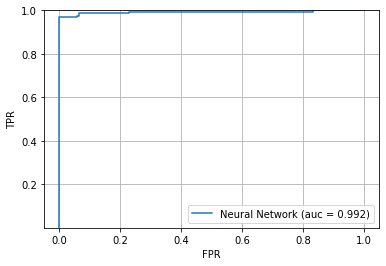

In [12]:
from sklearn.metrics import roc_curve, auc

graph_conv_filters = A_test 
graph_conv_filters = K.constant(graph_conv_filters)
Y_pred = model.predict([X_test, graph_conv_filters])

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(Y_test, Y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, label='Neural Network (auc = %0.3f)' % auc_keras)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()